In [219]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sqlite3

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

# Setting engine for SQLite connection
engine = create_engine("sqlite:///birthdata.sqlite", echo=False)


## Starting SQLite Connection

In [220]:
# Checking classes were made successfully: https://stackoverflow.com/questions/42946174/sqlalchemy-automap-not-generating-base-classes-table-name
engine = create_engine("sqlite:///birthdata.sqlite", echo=False)

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
print(Base.classes.keys())

# Create a session
session = Session(engine)


['clinic2010_county', 'clinic2010_state', 'clinic2015_county', 'clinic2015_state', 'county', 'national', 'outcomes']


### Naming Classes

In [221]:
# Assign the classes to variables
County2015 = Base.classes.clinic2015_county
State2015 = Base.classes.clinic2015_state
County2010 = Base.classes.clinic2010_county
State2010 = Base.classes.clinic2010_state
Outcomes = Base.classes.outcomes
County_births = Base.classes.county
State_births = Base.classes.national

## 1 Table Approach

### Selecting 1 Table for Modeling

In [278]:
# Switch out "selected" with the table of interest 
selected = County2015

# Display the row's columns and data in dictionary format
first_row = session.query(selected).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd6dd434310>,
 'state': 'Alabama',
 'dept_clinic_tt': 1,
 'fed_center': 1,
 'other_clinic_client': 0,
 'hospital_tt': 0,
 'dept_clinic': 1,
 'total_client_tt': 870.0,
 'fips': 1001,
 'pp_tt': 0,
 'hospital': 0,
 'fed_client_tt': 0,
 'other_clinic_tt': 0,
 'pp': 0,
 'dept_clinic_client_tt': 870,
 'county': 'Autauga ',
 'total_client': 1040.0,
 'other_clinic': 0,
 'hospital_client_tt': 0,
 'fed_client': 170,
 'total_titleten': 1,
 'pp_client_tt': 0,
 'dept_clinic_client': 870,
 'index': 0,
 'fed_center_tt': 0,
 'other_clinic_client_tt': 0,
 'hospital_client': 0,
 'pp_client': 0,
 'total_clinics': 2}

In [134]:
first_row = session.query(County_births).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd2d5391dc0>,
 'combined_fips_code': '1001',
 'state_fips_code': '01',
 'state': 'Alabama',
 'index': 0,
 'upper_confidence_limit': 55.2,
 'birth_rate': 48.4,
 'county_fips_code': '1',
 'county': 'Autauga',
 'year': 2003,
 'lower_confidence_limit': 42.1}

### Getting Query Results from 1 Table

In [4]:
# https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html#par_textimage_1574439295

import csv


In [6]:
state_populations.head()

,state,2010_population,2015_population
0,United States,309321666,320635163
1,Alabama,4785437,4852347
2,Alaska,713910,737498
3,Arizona,6407172,6829676
4,Arkansas,2921964,2978048


In [7]:
state_populations.dtypes

state              object
2010_population     int64
2015_population     int64
dtype: object

In [8]:
state_expenditures = pd.read_csv("family_planning_expenditures.csv", header=0, names=["state", "MCH block grant", "Medicaid_spending", "SSBG and TANF", "Title10_spending", "state appropriations", "total_spending"])

In [9]:
state_expenditures.dtypes

state                   object
MCH block grant         object
Medicaid_spending        int64
SSBG and TANF           object
Title10_spending         int64
state appropriations    object
total_spending           int64
dtype: object

In [10]:
state_expenditures = state_expenditures[["state","Medicaid_spending", "Title10_spending","total_spending"]]


In [11]:
state_expenditures.head()

,state,Medicaid_spending,Title10_spending,total_spending
0,Alabama,58362,58362,69742
1,Alaska,2812,2812,10158
2,Arizona,52006,52006,57560
3,Arkansas,6899,6899,11397
4,California,438559,438559,454706


In [275]:
county_populations = pd.read_csv("county_populations.csv", encoding='latin-1')

In [276]:
county_populations.head(10)

,state,county,2010_population,2015_population
0,Iowa,Adair,7682,7145
1,Kentucky,Adair,18656,19162
2,Missouri,Adair,25607,25353
3,Oklahoma,Adair,22683,22259
4,Colorado,Adams,441603,490443
5,Idaho,Adams,3976,3891
6,Illinois,Adams,67103,66835
7,Indiana,Adams,34387,34945
8,Iowa,Adams,4029,3754
9,Mississippi,Adams,32297,31561


In [224]:
county_populations.dtypes

state              object
county             object
2010_population     int64
2015_population     int64
dtype: object

## Multi-Table Approach

### Getting Query Results from Several Tables

In [225]:
#states



# This cell can be used if you want to compare data from different tables.
# 1) Identify tables before the period and consider what is the most logical way to merge them.
# 2) Pull in the columns of interest from each table 
# 3) Write out their join, keeping in mind 1 to 1, many to 1, etc. 
# 4) Update column names to match, keeping the first column as the element they were joined on. 
# 5) Update index to that joined column, renaming as needed 
# Resource: https://www.kite.com/python/answers/how-to-join-multiple-tables-together-in-sqlalchemy-in-python#:~:text=Use%20Query.,sequence%20to%20tables%20to%20join.


join_query = session.query(State2015.total_clinics, State2015.total_titleten, State2015.pp,\
                           State2015.dept_clinic, State2015.dept_clinic_tt, State2015.hospital_tt,\
                           State2015.hospital, State2015.pp_tt, State2015.pp_client, \
                           State2015.total_client,State2015.total_client_tt,\
                           State_births.state_rate, State_births.year, State_births.state)\
                    .join(State_births, State_births.state == State2015.state)\
                    .filter(State_births.year=="2016").filter(State_births.age_group=="15-19 years")


state_df = pd.DataFrame(join_query, columns=["total_clinics", "total_title10", "total_pp", "dept_clinic", "dept_clinic_tt", "hospital_tt", "hospital", "pp_tt", "pp_client", "total_client", "total_client_tt", "birth_rate", "year", "state"])
#joined_df.set_index('state_name', inplace=True, )

# See code above to change data types if needed
# Drop NaN rows, which will mess with the ML
state_df = state_df.dropna()



In [288]:
# counties

join_query = session.query(County2015.fips, County2015.total_clinics, County2015.total_titleten, County2015.pp,\
                           County2015.dept_clinic, County2015.hospital, County2015.total_client_tt,\
                           County2015.pp_client, County2015.dept_clinic_tt, County2015.pp_tt,\
                           County2015.total_client, County2015.hospital_client, County_births.birth_rate,\
                           County_births.year, County_births.state, County_births.county)\
                    .join(County_births, County_births.combined_fips_code == County2015.fips)\
                    .filter(County_births.year=="2016")


county_df = pd.DataFrame(join_query, columns=["FIPS", "total_clinics", "total_title10", "total_pp", "health_dept_clinics", "hospitals","title_10_clients","pp_clients", "dept_clinic_title10","pp_tt","total_clients","hospital_client","birth_rate", "year", "state", "county"])
#joined_df.set_index('state_name', inplace=True, )

# See code above to change data types if needed
# Drop NaN rows, which will mess with the ML
county_df = county_df.dropna()

In [289]:
county_df.loc[county_df["total_clinics"]==0]

,FIPS,total_clinics,total_title10,total_pp,health_dept_clinics,hospitals,title_10_clients,pp_clients,dept_clinic_title10,pp_tt,total_clients,hospital_client,birth_rate,year,state,county
72,2068,0,0,0,0,0,0.0,0,0,0,0.0,0,12.0,2016,Alaska,Denali
171,5133,0,0,0,0,0,0.0,0,0,0,0.0,0,53.4,2016,Arkansas,Sevier
242,8009,0,0,0,0,0,0.0,0,0,0,0.0,0,34.4,2016,Colorado,Baca
248,8019,0,0,0,0,0,0.0,0,0,0,0.0,0,11.6,2016,Colorado,Clear Creek
251,8025,0,0,0,0,0,0.0,0,0,0,0.0,0,33.1,2016,Colorado,Crowley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,55077,0,0,0,0,0,0.0,0,0,0,0.0,0,15.6,2016,Wisconsin,Marquette
3084,55089,0,0,0,0,0,0.0,0,0,0,0.0,0,2.6,2016,Wisconsin,Ozaukee
3115,56009,0,0,0,0,0,0.0,0,0,0,0.0,0,33.5,2016,Wyoming,Converse
3122,56023,0,0,0,0,0,0.0,0,0,0,0.0,0,18.7,2016,Wyoming,Lincoln


In [290]:
county_df["year"].unique()

array([2016])

In [291]:
county_df = county_df.merge(county_populations, how='left', on=["state","county"])

In [292]:
county_SVI = pd.read_csv("2016_SVI_extract.csv")

In [293]:
county_SVI=county_SVI.drop(columns=["state","county"])

In [295]:
county_df=county_df.merge(county_SVI, how='left', on="FIPS")

In [296]:
county_df = county_df.dropna()
county_df.shape

(3048, 21)

In [297]:
county_df.columns

Index(['FIPS', 'total_clinics', 'total_title10', 'total_pp',
       'health_dept_clinics', 'hospitals', 'title_10_clients', 'pp_clients',
       'dept_clinic_title10', 'pp_tt', 'total_clients', 'hospital_client',
       'birth_rate', 'year', 'state', 'county', '2010_population',
       '2015_population', 'SVI_sum_of_indicators', 'SVI_ranking',
       'percent_uninsured'],
      dtype='object')

In [298]:
county_df["clinics_per_capita"] = county_df["total_clinics"]/county_df["2015_population"]
county_df["title10_clinics_per_capita"] = county_df["total_title10"]/county_df["2015_population"]
county_df["pp_per_capita"] = county_df["total_pp"]/county_df["2015_population"]
county_df["health_dept_per_capita"] = county_df['health_dept_clinics']/county_df["2015_population"]
county_df["hospitals_per_capita"] = county_df['hospitals']/county_df["2015_population"]
county_df["title_10_clients_per_capita"] = county_df["title_10_clients"]/county_df["2015_population"]
county_df["pp_clients_per_capita"] = county_df['pp_clients']/county_df["2015_population"]
county_df["dept_clinic_title10_per_capita"] = county_df['dept_clinic_title10']/county_df["2015_population"]


In [262]:
# county_df["percent_clinics_tt_funded"] = county_df['total_title10']/county_df["total_clinics"]
# county_df["percent_clients_at_pp"] = county_df['pp_clients']/county_df["total_clients"]
# county_df["percent_clients_at_hospital"] = county_df['hospital_client']/county_df["total_clients"]
# county_df["percent_clients_using_tt"] = county_df['title_10_clients']/county_df["total_clients"]
# county_df = county_df.dropna()

In [299]:
#binary encode existence of title ten funding for planned parenthood?

for index, row in county_df.iterrows():
    if row["total_pp"] == 0:
        county_df.loc[index, "binary_pp"]=0
    else:
        county_df.loc[index, "binary_pp"]=1
    if row["pp_tt"] == 0:
        county_df.loc[index, "binary_pp_tt"]=0
    else:
        county_df.loc[index, "binary_pp_tt"]=1

In [203]:
state_df = state_df.merge(state_populations, on="state", how="inner")

In [204]:
state_df = state_df.merge(state_expenditures, on="state", how="inner")

In [45]:
state_df.head()

,total_clinics,total_title10,total_pp,dept_clinic,dept_clinic_tt,hospital_tt,hospital,pp_tt,pp_client,total_client,total_client_tt,birth_rate,year,state,2010_population,2015_population,Medicaid_spending,Title10_spending,total_spending
0,187,83,2,77,75,0,1,0,260,97940,86180,28.4,2016,Alabama,4785437,4852347,58362,58362,69742
1,157,5,5,16,1,0,0,3,3670,19570,5290,25.8,2016,Alaska,713910,737498,2812,2812,10158
2,232,36,12,33,14,1,18,6,23930,84190,31820,23.6,2016,Arizona,6407172,6829676,52006,52006,57560
3,163,92,2,92,90,0,0,2,4590,55430,51510,34.6,2016,Arkansas,2921964,2978048,6899,6899,11397
4,1697,353,116,94,43,2,371,110,712470,1670600,1014320,17.0,2016,California,37319502,38918045,438559,438559,454706


In [46]:
state_df["clinics_per_capita"] = state_df["total_clinics"]/state_df["2015_population"]
state_df["title10_per_capita"] = state_df["total_title10"]/state_df["2015_population"]
state_df["pp_per_capita"] = state_df["total_pp"]/state_df["2015_population"]
state_df["health_dept_per_capita"] = state_df['dept_clinic']/state_df["2015_population"]
state_df["hospitals_per_capita"] = state_df['hospital']/state_df["2015_population"]
state_df["title_10_clients_per_capita"] = state_df["total_client_tt"]/state_df["2015_population"]
state_df["pp_clients_per_capita"] = state_df['pp_client']/state_df["2015_population"]
state_df["dept_clinic_title10_per_capita"] = state_df['dept_clinic_tt']/state_df["2015_population"]
state_df["percent_clinics_tt_funded"] = state_df['total_title10']/state_df["total_clinics"]
state_df["percent_pp_tt_funded"] = state_df['pp_tt']/state_df["total_pp"]
state_df["percent_clients_at_pp"] = state_df['pp_client']/state_df["total_client"]
state_df["Medicaid_spending_per_capita"] = state_df["Medicaid_spending"]/state_df["2015_population"]
state_df["Title10_spending_per_capita"] = state_df["Title10_spending"]/state_df["2015_population"]
state_df["total_spending_per_capita"] = state_df["total_spending"]/state_df["2015_population"]


In [142]:
county_df=county_df.dropna()

In [300]:
county_df.columns

Index(['FIPS', 'total_clinics', 'total_title10', 'total_pp',
       'health_dept_clinics', 'hospitals', 'title_10_clients', 'pp_clients',
       'dept_clinic_title10', 'pp_tt', 'total_clients', 'hospital_client',
       'birth_rate', 'year', 'state', 'county', '2010_population',
       '2015_population', 'SVI_sum_of_indicators', 'SVI_ranking',
       'percent_uninsured', 'clinics_per_capita', 'title10_clinics_per_capita',
       'pp_per_capita', 'health_dept_per_capita', 'hospitals_per_capita',
       'title_10_clients_per_capita', 'pp_clients_per_capita',
       'dept_clinic_title10_per_capita', 'binary_pp', 'binary_pp_tt'],
      dtype='object')

## Prepping the Model Data

In [308]:
# Close the session from before
session.close()

# Assign the data to X and y
# Note: Sklearn requires a two-dimensional array of values so we use reshape to create this

X = county_df[['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']]
y = county_df["birth_rate"]

feature_names = ['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']

print("Shape: ", X.shape, y.shape)

Shape:  (3048, 11) (3048,)


In [309]:
# Use sklearn's `train_test_split` to split the data into training and testing
# Keep in mind that our group may want to use the model on an entirely different table as well. 

from sklearn.model_selection import train_test_split # may not apply to all models

### BEGIN SOLUTION 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### END SOLUTION

## Linear Regression

In [310]:
# Create the model

### BEGIN SOLUTION

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=1)

### END SOLUTION

In [311]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=1)

In [312]:
# Calculate the mean_squared_error and the r-squared value
# for the testing data

from sklearn.metrics import mean_squared_error, r2_score

### BEGIN SOLUTION

# Use our model to make predictions
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### END SOLUTION

Mean Squared Error (MSE): 105.3278903816511
R-squared (R2 ): 0.3354231074959102


In [313]:
# Call the `score` method on the model to show the r2 score

### BEGIN SOLUTION
model.score(X_test, y_test)
### END SOLUTION

0.3354231074959102

In [314]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.6572343878050463, 'percent_uninsured'),
 (0.0859254844348129, 'clinics_per_capita'),
 (0.07054225662751744, 'health_dept_per_capita'),
 (0.060145936547776745, 'title_10_clients_per_capita'),
 (0.048838334192067394, 'title10_clinics_per_capita'),
 (0.04666037569405009, 'dept_clinic_title10_per_capita'),
 (0.011826235435914325, 'pp_clients_per_capita'),
 (0.009254904092271718, 'pp_per_capita'),
 (0.0061908821269299015, 'hospitals_per_capita'),
 (0.0029010946891278007, 'binary_pp'),
 (0.00048010835448547497, 'binary_pp_tt')]

## 

In [315]:
SVI = county_df[['SVI_sum_of_indicators']]

In [316]:
X_train, X_test, y_train, y_test = train_test_split(SVI, y, random_state=1)

In [317]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=1)

In [318]:
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 93.91595348442462
R-squared (R2 ): 0.407427868372928


Text(0, 0.5, 'Birth Rate')

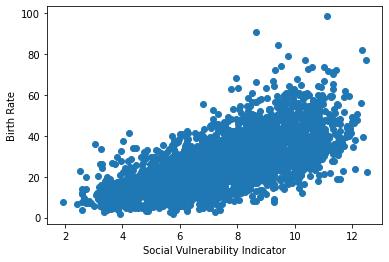

In [369]:
plt.scatter(SVI, y)
plt.xlabel("Social Vulnerability Indicator")
plt.ylabel("Birth Rate")

In [ ]:
#R2 with raw state data = 0.26
#R2 with per capita = 0.15
#r2 pp, title10, total clinics, states raw plus per capita = .29, pp per capita highest feature importance
#r2 states with per capita and percent of different clinic tt funded, .316

In [325]:
county_df=county_df.sort_values(by=['SVI_sum_of_indicators'])

In [334]:
county_df['SVI_sum_of_indicators']

282      1.9147
645      2.4187
1687     2.5091
1728     2.5842
1610     2.5985
         ...   
2741    12.2951
2517    12.3448
1774    12.3728
1787    12.4680
52      12.5072
Name: SVI_sum_of_indicators, Length: 3048, dtype: float64

In [335]:
low_SVI = county_df.iloc[:1016,:]

In [336]:
medium_SVI = county_df.iloc[1016:2032,:]

In [337]:
high_SVI = county_df.iloc[2032:,:]

In [364]:
low_SVI_X = low_SVI[['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']]
low_SVI_y = low_SVI["birth_rate"]

feature_names = ['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']

print("Shape: ", low_SVI_X.shape, low_SVI_y.shape)

Shape:  (1016, 11) (1016,)


In [365]:
low_X_train, low_X_test, low_y_train, low_y_test = train_test_split(low_SVI_X, low_SVI_y, random_state=1)

In [366]:
model.fit(low_X_train, low_y_train)

RandomForestRegressor(max_depth=7, random_state=1)

In [367]:
low_predicted = model.predict(low_X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(low_y_test, low_predicted)
r2 = r2_score(low_y_test, low_predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 53.6990854156242
R-squared (R2 ): 0.036181435922571836


In [368]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.45831457345302035, 'percent_uninsured'),
 (0.1563441696462406, 'clinics_per_capita'),
 (0.1148433252484689, 'pp_clients_per_capita'),
 (0.09665724206599785, 'title_10_clients_per_capita'),
 (0.06684976587924202, 'title10_clinics_per_capita'),
 (0.035569951678650825, 'health_dept_per_capita'),
 (0.02996343340972394, 'dept_clinic_title10_per_capita'),
 (0.024496993277087604, 'pp_per_capita'),
 (0.009233717069682339, 'hospitals_per_capita'),
 (0.004335596175100025, 'binary_pp'),
 (0.003391232096785477, 'binary_pp_tt')]

In [359]:
mid_SVI_X = medium_SVI[['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']]
mid_SVI_y = medium_SVI["birth_rate"]

feature_names = ['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']

print("Shape: ", mid_SVI_X.shape, mid_SVI_y.shape)

Shape:  (1016, 11) (1016,)


In [360]:
mid_X_train, mid_X_test, mid_y_train, mid_y_test = train_test_split(mid_SVI_X, mid_SVI_y, random_state=1)

In [361]:
model.fit(mid_X_train, mid_y_train)

RandomForestRegressor(max_depth=7, random_state=1)

In [362]:
mid_predicted = model.predict(mid_X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(mid_y_test, mid_predicted)
r2 = r2_score(mid_y_test, mid_predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 72.6385200283917
R-squared (R2 ): 0.23323342727535012


In [363]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.31368340762615365, 'percent_uninsured'),
 (0.1405508015281676, 'title_10_clients_per_capita'),
 (0.12806797553012816, 'clinics_per_capita'),
 (0.12443878751547613, 'pp_clients_per_capita'),
 (0.09962690428033649, 'title10_clinics_per_capita'),
 (0.06550129416138822, 'health_dept_per_capita'),
 (0.060279186840883264, 'dept_clinic_title10_per_capita'),
 (0.032776182552813456, 'hospitals_per_capita'),
 (0.019086229683915153, 'binary_pp_tt'),
 (0.012856089379629, 'pp_per_capita'),
 (0.0031331409011088507, 'binary_pp')]

In [353]:
high_SVI_X = high_SVI[['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']]
high_SVI_y = high_SVI["birth_rate"]

feature_names = ['clinics_per_capita',
       'title10_clinics_per_capita', 'pp_per_capita', 'health_dept_per_capita',
       'hospitals_per_capita', 'title_10_clients_per_capita',
       'pp_clients_per_capita', 'dept_clinic_title10_per_capita','binary_pp',
       'binary_pp_tt','percent_uninsured']

print("Shape: ", high_SVI_X.shape, high_SVI_y.shape)

Shape:  (1016, 11) (1016,)


In [354]:
high_X_train, high_X_test, high_y_train, high_y_test = train_test_split(high_SVI_X, high_SVI_y, random_state=1)

In [355]:
model.fit(high_X_train, high_y_train)

RandomForestRegressor(max_depth=7, random_state=1)

In [356]:
high_predicted = model.predict(high_X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(high_y_test, high_predicted)
r2 = r2_score(high_y_test, high_predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 129.66166225302067
R-squared (R2 ): 0.17434620008922186


In [357]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.39066175199751635, 'percent_uninsured'),
 (0.13631572893091307, 'clinics_per_capita'),
 (0.10519565190351263, 'health_dept_per_capita'),
 (0.09856304857736356, 'pp_clients_per_capita'),
 (0.0767413360544299, 'title_10_clients_per_capita'),
 (0.06885277079204526, 'title10_clinics_per_capita'),
 (0.05857496089674867, 'dept_clinic_title10_per_capita'),
 (0.031145026519825057, 'pp_per_capita'),
 (0.027697378381581535, 'binary_pp'),
 (0.004914077894458372, 'hospitals_per_capita'),
 (0.0013382680516053802, 'binary_pp_tt')]